**Using Unsupervised Learning models to detect whether the dataset contains anomalies or not**

The dataset contains 7,267 instances of a device's temperature (in Fahrenheit degrees). The matrix being 7267 x 2 means the dataset contains two columns: the timestamp and its corresponding temperature. Using this data, we intend to use feature engineering to help us visualize temporal patterns. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy import stats

In [2]:
tempDeviceFailure = pd.read_csv("temperature_device_failure.csv")

tempDeviceFailure.head(3)

timestamp      value
0  7/4/2013 0:00  69.880835
1  7/4/2013 1:00  71.220227
2  7/4/2013 2:00  70.877805

In [3]:
print(tempDeviceFailure.isnull().any())

timestamp    False
value        False
dtype: bool


In [4]:
tempDeviceFailure.describe()

value
count  7267.000000
mean     71.242433
std       4.247509
min      57.458406
25%      68.369411
50%      71.858493
75%      74.430958
max      86.223213

**Plotting / visualizing the "original" dataset using a Time Series object.**

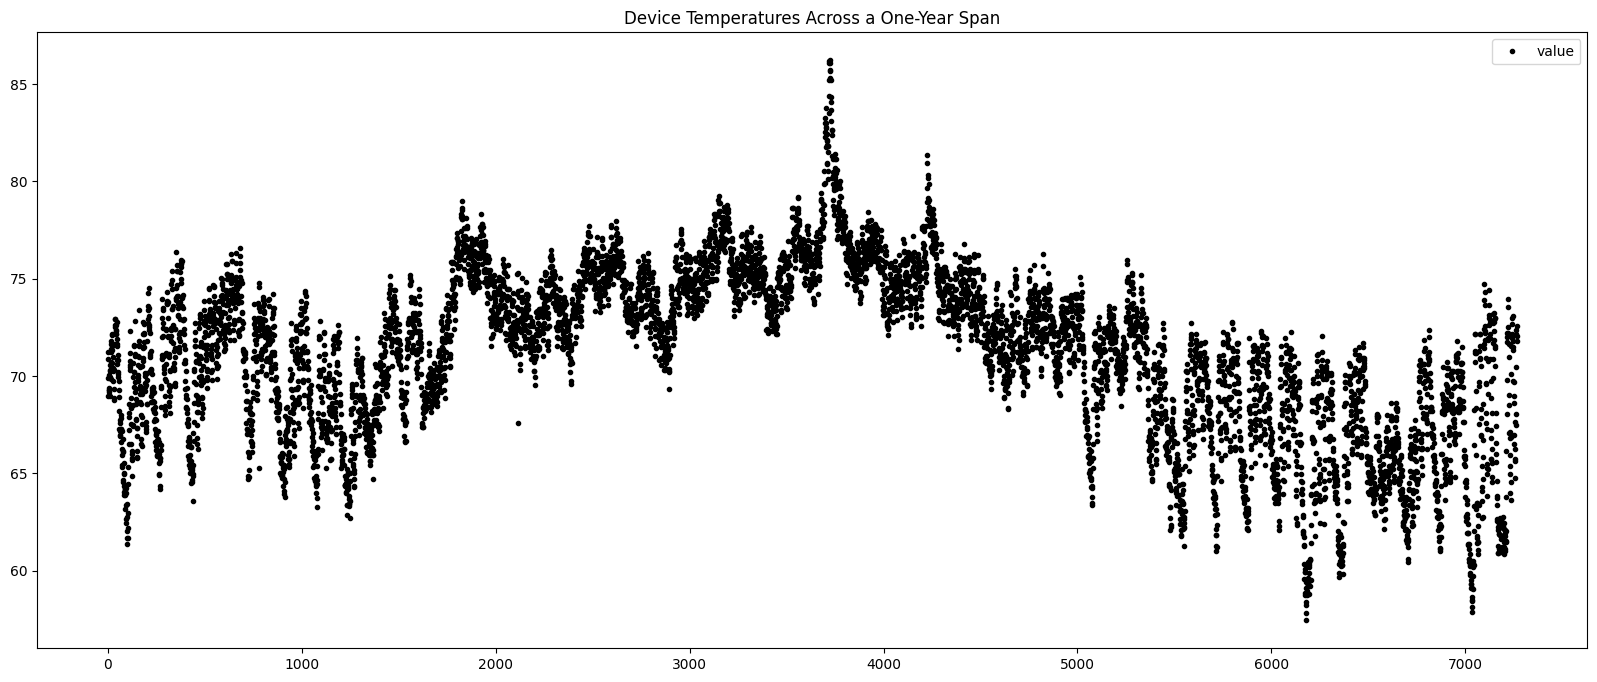

In [5]:
tempDeviceFailure.plot(style = "k.", figsize = (20, 8), title = "Device Temperatures Across a One-Year Span")
plt.show()

In [6]:
graph = px.scatter(tempDeviceFailure, x = "timestamp", y = "value")
graph.update_xaxes(rangeslider_visible = True)
graph.show()

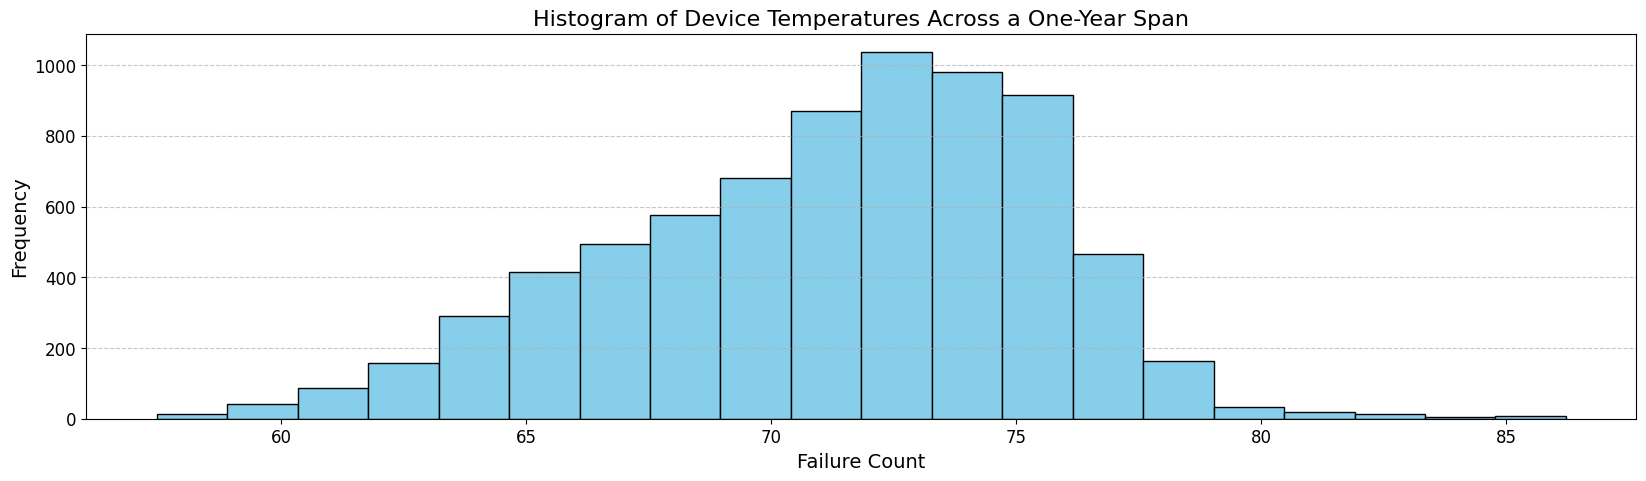

In [7]:
ax = tempDeviceFailure.hist(bins = 20, figsize = (20, 5), color = "skyblue", edgecolor = "black", grid = False)

plt.title("Histogram of Device Temperatures Across a One-Year Span", fontsize = 16)
plt.xlabel("Failure Count", fontsize = 14)
plt.ylabel("Frequency", fontsize = 14)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.grid(axis = "y", linestyle = "--", alpha = 0.7)
plt.show()

**Performing Feature Engineering on the dataset such that new features can be added.**

In [8]:
tdf = tempDeviceFailure.copy()
tdf.dtypes

timestamp     object
value        float64
dtype: object

In [9]:
tdf["timestamp"] = pd.to_datetime(tdf["timestamp"])
tdf.dtypes

timestamp    datetime64[ns]
value               float64
dtype: object

**Creating new features: Weekday Day, Weekday Night, Weekend Day, and Weekend Night.**

"Day" is defined as 7:00am - 7:00pm; and "Night" as 7:01pm - 6:59am.

The goal is to figure out when (weekday, weekend, day or night) the device fails!

In [10]:
from datetime import datetime

tdf["dayOfWeek"] = tdf["timestamp"].dt.day_name()
tdf["day"] = tdf["timestamp"].dt.weekday
tdf["time"] = tdf["timestamp"].dt.time
tdf["hour"] = tdf["timestamp"].dt.hour
tdf["month"] = tdf["timestamp"].dt.month
tdf.head(3)

timestamp      value dayOfWeek  day      time  hour  month
0 2013-07-04 00:00:00  69.880835  Thursday    3  00:00:00     0      7
1 2013-07-04 01:00:00  71.220227  Thursday    3  01:00:00     1      7
2 2013-07-04 02:00:00  70.877805  Thursday    3  02:00:00     2      7

In [11]:
tdf.dtypes

timestamp    datetime64[ns]
value               float64
dayOfWeek            object
day                   int32
time                 object
hour                  int32
month                 int32
dtype: object

In [12]:
dayConditions = [(tdf["day"] >= 5),
                 (tdf["day"] < 5)]

dayValues = ["weekend", "weekday"]

tdf["dayType"] = np.select(dayConditions, dayValues)

timeConditions = [(tdf["hour"] >= 7) & (tdf["hour"] <= 19),
                  (tdf["hour"] > 19) & (tdf["hour"] < 24),
                  (tdf["hour"] < 7) & (tdf["hour"] >= 0)]

timeValues = ["day", "night", "night"]

tdf["timeframe"] = np.select(timeConditions, timeValues)

seasonConditions = [(tdf["month"] >= 0) & (tdf["month"] <= 2),
                    (tdf["month"] >= 3) & (tdf["month"] <= 5),
                    (tdf["month"] >= 6) & (tdf["month"] <= 8),
                    (tdf["month"] >= 9) & (tdf["month"] <= 12)]

seasonValues = ["winter", "spring", "summer", "fall"]

tdf["season"] = np.select(seasonConditions, seasonValues)

tdf.head(3)

timestamp      value dayOfWeek  day      time  hour  month  \
0 2013-07-04 00:00:00  69.880835  Thursday    3  00:00:00     0      7   
1 2013-07-04 01:00:00  71.220227  Thursday    3  01:00:00     1      7   
2 2013-07-04 02:00:00  70.877805  Thursday    3  02:00:00     2      7   

   dayType timeframe  season  
0  weekday     night  summer  
1  weekday     night  summer  
2  weekday     night  summer

In [13]:
conditions = [(tdf["dayType"] == "weekend") & (tdf["timeframe"] == "day"),
              (tdf["dayType"] == "weekend") & (tdf["timeframe"] == "night"),
              (tdf["dayType"] == "weekday") & (tdf["timeframe"] == "day"),
              (tdf["dayType"] == "weekday") & (tdf["timeframe"] == "night")]

values = ["weekend day", "weekend night", "weekday day", "weekday night"]

tdf["timePeriod"] = np.select(conditions, values)
tdf.head(3)

timestamp      value dayOfWeek  day      time  hour  month  \
0 2013-07-04 00:00:00  69.880835  Thursday    3  00:00:00     0      7   
1 2013-07-04 01:00:00  71.220227  Thursday    3  01:00:00     1      7   
2 2013-07-04 02:00:00  70.877805  Thursday    3  02:00:00     2      7   

   dayType timeframe  season     timePeriod  
0  weekday     night  summer  weekday night  
1  weekday     night  summer  weekday night  
2  weekday     night  summer  weekday night

In [14]:
tdf.shape

(7267, 11)

In [15]:
tdf["timePeriod"].value_counts()

timePeriod
weekday day      2843
weekday night    2400
weekend day      1092
weekend night     932
Name: count, dtype: int64

In [16]:
px.histogram(tdf, x = "value")

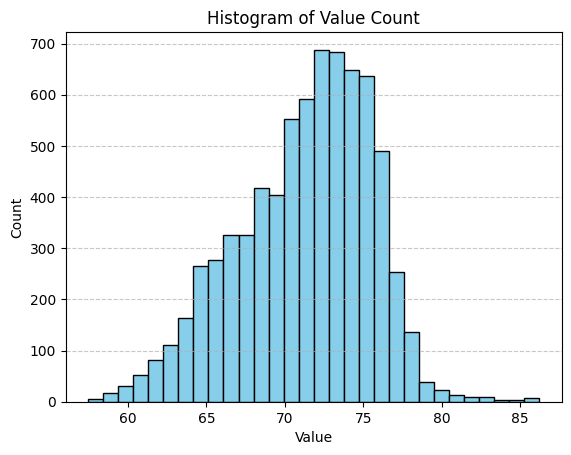

In [17]:
timePeriodData = tdf["value"]

plt.hist(timePeriodData, bins = 30, color = "skyblue", edgecolor = "black")

plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Histogram of Value Count")

plt.grid(axis = "y", linestyle = "--", alpha = 0.7)
plt.show()

In [18]:
px.histogram(tdf, x = "season")

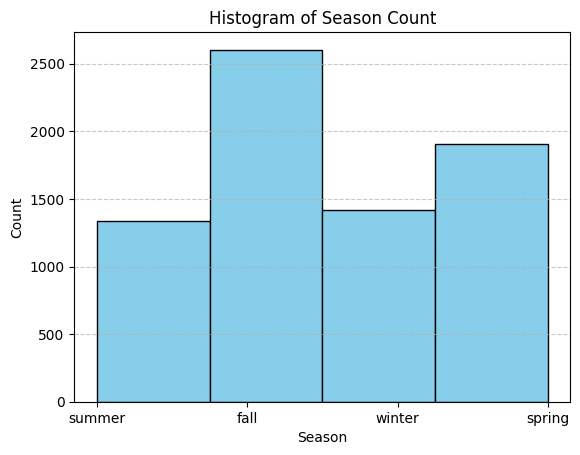

In [19]:
timePeriodData = tdf["season"]

plt.hist(timePeriodData, bins = 4, color = "skyblue", edgecolor = "black")

plt.xlabel("Season")
plt.ylabel("Count")
plt.title("Histogram of Season Count")

plt.grid(axis = "y", linestyle = "--", alpha = 0.7)
plt.show()

In [20]:
hist = px.histogram(tdf, x = "timePeriod")
hist.show()

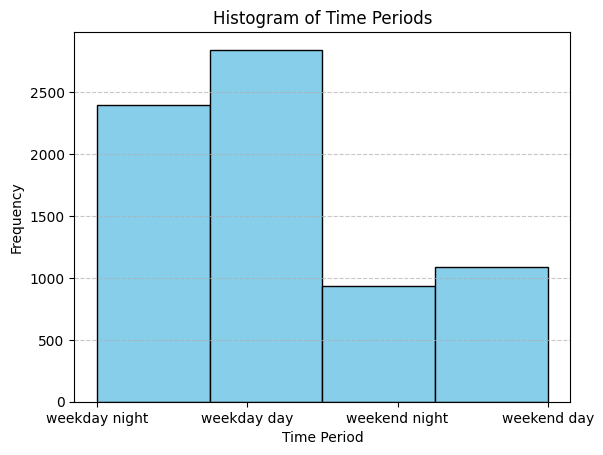

In [21]:
timePeriodData = tdf["timePeriod"]

plt.hist(timePeriodData, bins = 4, color = "skyblue", edgecolor = "black")

plt.xlabel("Time Period")
plt.ylabel("Frequency")
plt.title("Histogram of Time Periods")

plt.grid(axis = "y", linestyle = "--", alpha = 0.7)
plt.show()

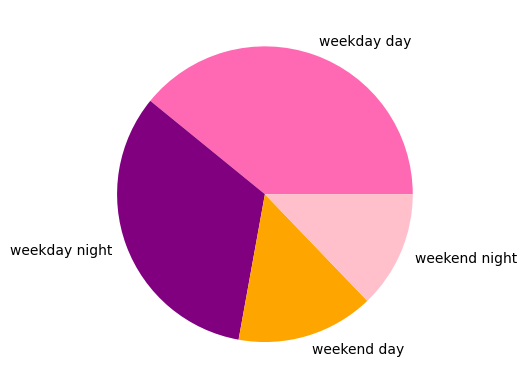

In [22]:
y = np.array([2843, 2400, 1092, 932])
labels = ["weekday day", "weekday night", "weekend day", "weekend night"]
colors = ["hotpink", "purple", "orange", "pink"]

plt.pie(y, labels = labels, colors = colors)
plt.show()

In [23]:
hist = px.histogram(tdf, x = "timePeriod", y = "value", histfunc = "avg", nbins = 8, text_auto = True)
hist.show()

**Applying K-Means to the revised dataset and determining the best value for K.**

In [24]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score
scaler = StandardScaler()

In [25]:
from sklearn.preprocessing import LabelEncoder

tdf1 = tdf.copy()

numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
categoricalColumns = []
features = tdf.columns.values.tolist()

for col in features:
    if tdf1[col].dtype in numerics: continue
    categoricalColumns.append(col)

for col in categoricalColumns:
    if col in tdf1.columns:
        le = LabelEncoder()
        le.fit(list(tdf1[col].astype(str).values))
        tdf1[col] = le.transform(list(tdf1[col].astype(str).values))

tdf1.head(3)

timestamp      value  dayOfWeek  day  time  hour  month  dayType  \
0          0  69.880835          4    3     0     0      7        0   
1          1  71.220227          4    3     1     1      7        0   
2          2  70.877805          4    3     2     2      7        0   

   timeframe  season  timePeriod  
0          1       2           1  
1          1       2           1  
2          1       2           1

In [26]:
X = tdf1.iloc[:, : -1].values
y = tdf1.iloc[:, -1].values

xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.20)

In [27]:
from sklearn.cluster import KMeans, MiniBatchKMeans

def check():
    err = {}

    X = tdf1.iloc[:, : -1].values
    y = tdf1.iloc[:, -1].values
    xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.20)

    for n_init in [10, 1]:
        err[n_init] = 0

        for _ in range(10):
            k = 5
            kMeans = KMeans(n_clusters = k, n_init = n_init)
            yPred = kMeans.fit_predict(X)
            err[n_init] += kMeans.inertia_
    
    print(f"Mean error for n_init = 1 is {err[1]/err[10]-1:.2%} higher than for n_init = 10")

for i in range(10):
    check()

Mean error for n_init = 1 is 0.01% higher than for n_init = 10
Mean error for n_init = 1 is 0.00% higher than for n_init = 10
Mean error for n_init = 1 is 0.02% higher than for n_init = 10
Mean error for n_init = 1 is 0.02% higher than for n_init = 10
Mean error for n_init = 1 is 0.03% higher than for n_init = 10
Mean error for n_init = 1 is 0.02% higher than for n_init = 10
Mean error for n_init = 1 is 0.02% higher than for n_init = 10
Mean error for n_init = 1 is 0.02% higher than for n_init = 10
Mean error for n_init = 1 is 0.02% higher than for n_init = 10
Mean error for n_init = 1 is 0.02% higher than for n_init = 10


In [28]:
k = 5
kMeans = KMeans(n_clusters = k, n_init = 10)
yPred = kMeans.fit_predict(X)

kMeans.cluster_centers_

array([[ 7.34500000e+02,  6.97438961e+01,  2.93333333e+00,
         3.02517007e+00,  1.14741497e+01,  1.14741497e+01,
         7.65510204e+00,  2.80272109e-01,  4.59183673e-01,
         1.81904762e+00],
       [ 5.11400000e+03,  7.06168225e+01,  3.02217602e+00,
         2.91337491e+00,  1.15204435e+01,  1.15204435e+01,
         2.12959113e+00,  2.59182259e-01,  4.60845461e-01,
         2.33610534e+00],
       [ 3.66450000e+03,  7.58797067e+01,  2.99175824e+00,
         3.07692308e+00,  1.15000000e+01,  1.15000000e+01,
         8.40659341e+00,  2.93956044e-01,  4.55357143e-01,
         9.31318681e-01],
       [ 6.55100000e+03,  6.64393982e+01,  3.03703704e+00,
         3.00978337e+00,  1.14912648e+01,  1.14912648e+01,
         4.31027254e+00,  2.97693920e-01,  4.60517121e-01,
         1.00000000e+00],
       [ 2.20300000e+03,  7.34420753e+01,  3.06066803e+00,
         2.91751875e+00,  1.15603272e+01,  1.15603272e+01,
         1.00783913e+01,  2.61758691e-01,  4.56714383e-01,
        -2.

In [29]:
miniBatchKMeans = MiniBatchKMeans(n_clusters = 5, n_init = 10)
miniBatchKMeans.fit(X)

MiniBatchKMeans(n_clusters=5, n_init=10)

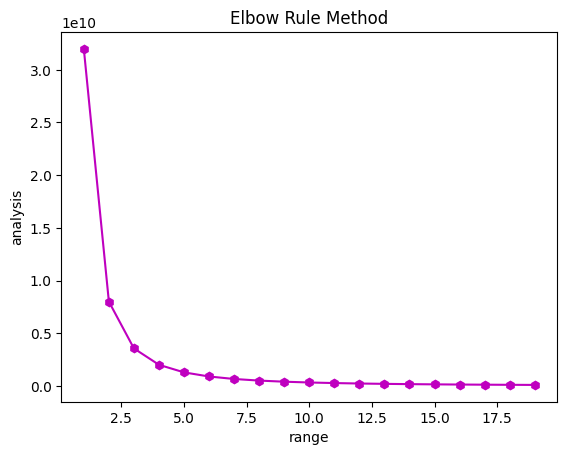

In [30]:
analysis = []
k = range(1, 20)

for i in k:
    kMeans = KMeans(n_clusters = i, n_init = 10)
    kMeans.fit(X)
    analysis.append(kMeans.inertia_)

plt.plot(k, analysis, "hm-")
plt.xlabel("range")
plt.ylabel("analysis")
plt.title("Elbow Rule Method")
plt.show()

In [31]:
from sklearn.metrics import silhouette_score

sil = silhouette_score(X, kMeans.labels_)
print(sil)

0.5221820170214696


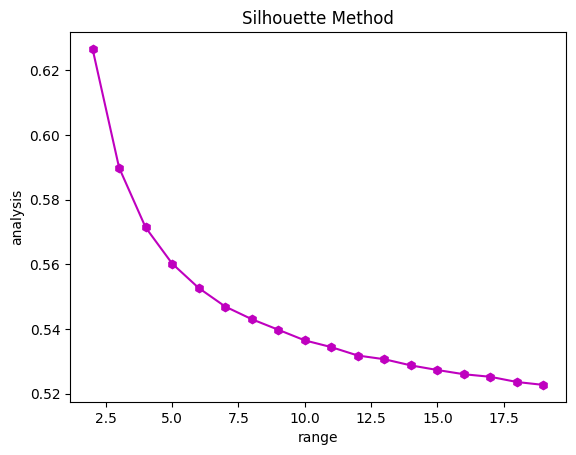

In [32]:
sil = []

for i in range(2, 20):
    kMeans = KMeans(n_clusters = i, random_state = 42, n_init = 10).fit(X)
    clusterLabels = kMeans.labels_
    sil.append(silhouette_score(X, clusterLabels))

plt.plot(range(2, 20), sil, "hm-")
plt.xlabel("range")
plt.ylabel("analysis")
plt.title("Silhouette Method")
plt.show()

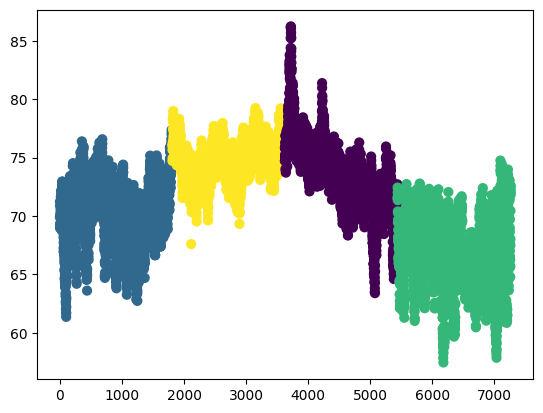

In [33]:
kMeans = KMeans(n_clusters = 4, random_state = 0, n_init = 10)
labels = kMeans.fit(X).predict(X)

plt.scatter(X[:, 0], X[:, 1], c = labels, s = 40, cmap = "viridis")

In [34]:
unique, counts = np.unique(labels, return_counts = True)

print(np.array((unique, counts)).T)

[[   0 1816]
 [   1 1813]
 [   2 1826]
 [   3 1812]]


In [35]:
from scipy.spatial.distance import cdist

def plotKMeans(kMeans, X, n_clusters = 4, rseed = 0, ax = None):
    labels = kMeans.fit_predict(X)

    ax = ax or plt.gca()
    ax.axis("equal")
    ax.scatter(X[:, 0], X[:, 1], c = labels, s = 40, cmap = "viridis", zorder = 2)
    ax.axis([0,7000,-2000,2000])

    centers = kMeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max() for i, center in enumerate(centers)]
    
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc = "#CCCCCC", lw = 3, alpha = 0.5, zorder = 1))

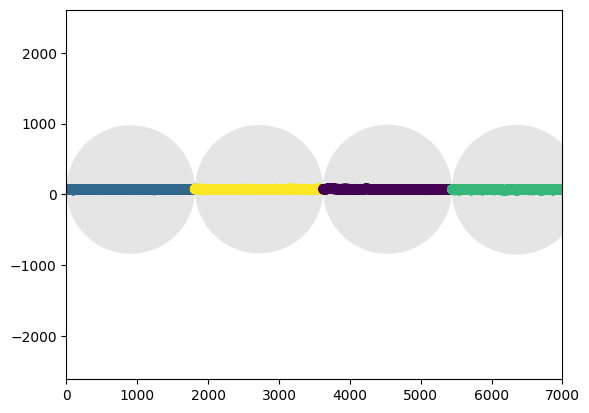

In [36]:
kMeans = KMeans(4, random_state = 0, n_init = 10)
plotKMeans(kMeans, X)

**Determining the best value of K and plotting K clusters in scatter plots, by choosing 2 features from the dataset.**

Principal Component Analysis (PCA) will also be applied to derive these 2 features.

In [37]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca = pca.fit_transform(tdf1)
pcaDf = pd.DataFrame(pca)
pcaDf.head()

0          1
0 -3632.997011 -16.499977
1 -3631.997866 -15.000793
2 -3630.997650 -13.612395
3 -3629.996430 -12.327811
4 -3628.996638 -10.895504

In [38]:
pca

array([[-3.63299701e+03, -1.64999769e+01],
       [-3.63199787e+03, -1.50007934e+01],
       [-3.63099765e+03, -1.36123952e+01],
       ...,
       [ 3.63099851e+03,  2.33963409e+00],
       [ 3.63199865e+03,  3.73600833e+00],
       [ 3.63299816e+03,  5.19695090e+00]])

In [39]:
kMeans = KMeans(n_clusters = 4, random_state = 42, n_init = 10)

kMeans.fit(pcaDf)
labels = kMeans.predict(pcaDf)
centroids = kMeans.cluster_centers_

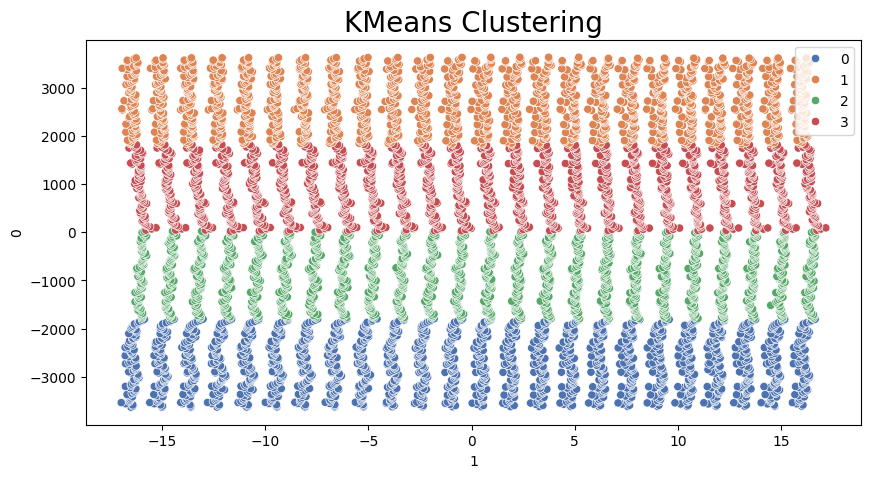

In [40]:
plt.figure(figsize = (10, 5))

sns.scatterplot(data = pcaDf, x = pcaDf.columns[1], y = pcaDf.columns[0], hue = labels, palette = "deep")

plt.title("KMeans Clustering", size = 20)
plt.legend(loc = "upper right")
plt.show()

In [41]:
np.random.seed(0)
matrix = np.random.randn(20, 5)

pca = PCA(n_components = 2)
pca = pca.fit(matrix)

print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[1.58691121 1.36183634]
[0.32047581 0.27502207]
[0.32047581 0.59549787]


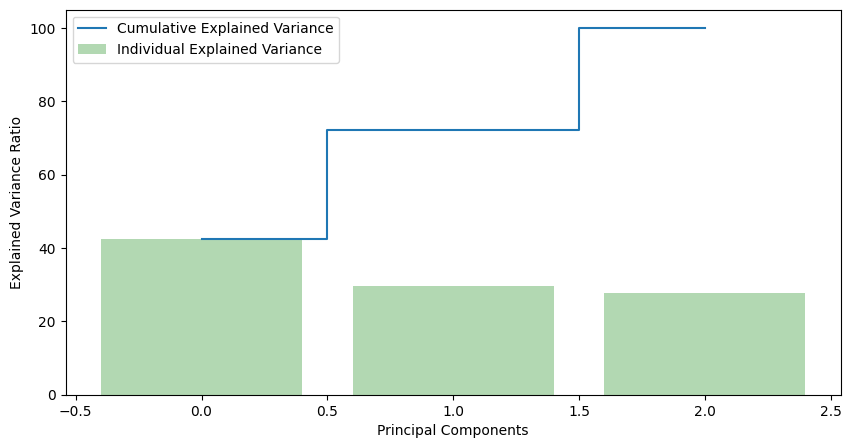

In [42]:
data = tdf1[["value", "hour", "timePeriod"]]

x = data.values
xStd = StandardScaler().fit_transform(x)
meanVector = np.mean(xStd, axis = 0)
covarianceMatrix = np.cov(xStd.T)
eigValues, eigVectors = np.linalg.eig(covarianceMatrix)
eigPairs = [(np.abs(eigValues[i]), eigVectors[:, i]) for i in range(len(eigValues))]
eigPairs.sort(key = lambda x: x[0], reverse = True)
tot = sum(eigValues)
variableExplained = [(i / tot) * 100 for i in sorted(eigValues, reverse = True)]
cumulativeVariableExplained = np.cumsum(variableExplained)

plt.figure(figsize = (10, 5))
plt.bar(range(len(variableExplained)), variableExplained, alpha = 0.3, 
        align = "center", label = "Individual Explained Variance", color = "g")

plt.step(range(len(cumulativeVariableExplained)), cumulativeVariableExplained, 
         where = "mid", label = "Cumulative Explained Variance")

plt.ylabel("Explained Variance Ratio")
plt.xlabel("Principal Components")
plt.legend(loc = "best")
plt.show()

In [43]:
k = 5
kMeans = KMeans(n_clusters = k, n_init = 10)
yPred = kMeans.fit_predict(X)

In [44]:
yPred

array([4, 4, 4, ..., 3, 3, 3])

In [45]:
yPred is kMeans.labels_

True

In [46]:
kMeans.cluster_centers_

array([[ 5.10100000e+03,  7.06591372e+01,  3.03239145e+00,
         2.93866299e+00,  1.15299793e+01,  1.15299793e+01,
         2.11095796e+00,  2.65334252e-01,  4.54858718e-01,
         2.35217092e+00],
       [ 2.18400000e+03,  7.34217963e+01,  3.00342231e+00,
         2.95345654e+00,  1.15236140e+01,  1.15236140e+01,
         1.00527036e+01,  2.62833676e-01,  4.59274470e-01,
        -4.21884749e-15],
       [ 3.64500000e+03,  7.58850568e+01,  3.02464066e+00,
         3.01437372e+00,  1.15154004e+01,  1.15154004e+01,
         8.53182752e+00,  2.81314168e-01,  4.57221081e-01,
         8.93223819e-01],
       [ 6.54650000e+03,  6.64545714e+01,  3.02638889e+00,
         3.02013889e+00,  1.14756944e+01,  1.14756944e+01,
         4.30208333e+00,  3.00000000e-01,  4.63888889e-01,
         1.00000000e+00],
       [ 7.26500000e+02,  6.97114546e+01,  2.95735901e+00,
         3.01650619e+00,  1.15013755e+01,  1.15013755e+01,
         7.64030261e+00,  2.83356259e-01,  4.57359010e-01,
         1.

In [47]:
inertia = kMeans.inertia_
print(inertia)

1280158663.360505


**Applying Gaussian distribution (EllipticEnvelope), and listing the anomalies / showing them graphically.**

array([[<Axes: xlabel='value', ylabel='value'>,
        <Axes: xlabel='hour', ylabel='value'>,
        <Axes: xlabel='timePeriod', ylabel='value'>],
       [<Axes: xlabel='value', ylabel='hour'>,
        <Axes: xlabel='hour', ylabel='hour'>,
        <Axes: xlabel='timePeriod', ylabel='hour'>],
       [<Axes: xlabel='value', ylabel='timePeriod'>,
        <Axes: xlabel='hour', ylabel='timePeriod'>,
        <Axes: xlabel='timePeriod', ylabel='timePeriod'>]], dtype=object)

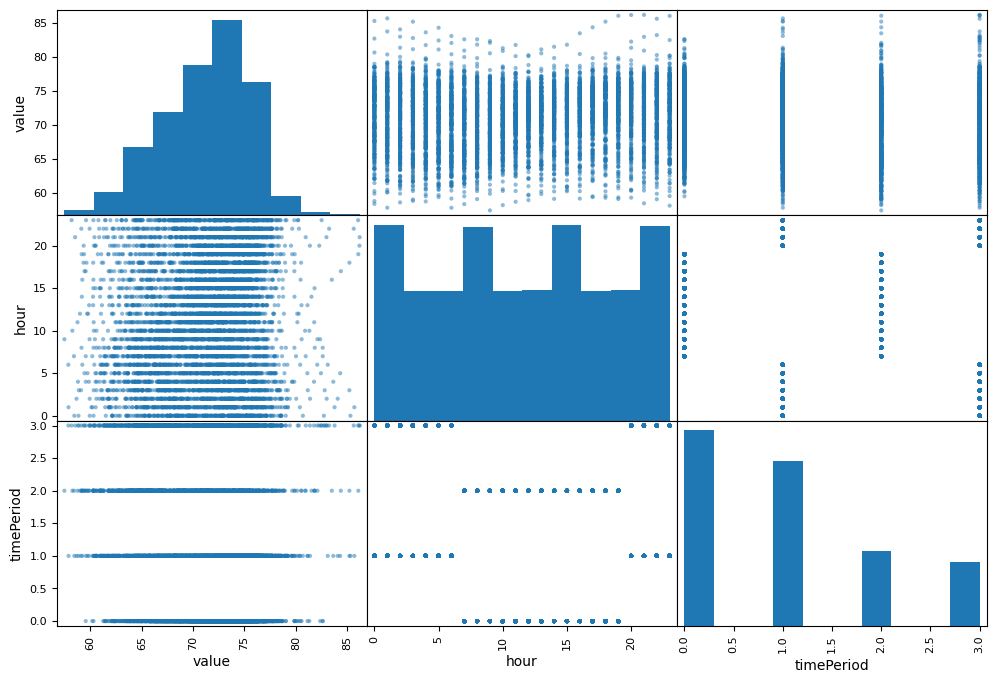

In [48]:
from pandas.plotting import scatter_matrix

attributes = ["value", "hour", "timePeriod"]
scatter_matrix(tdf1[attributes], figsize = (12, 8))

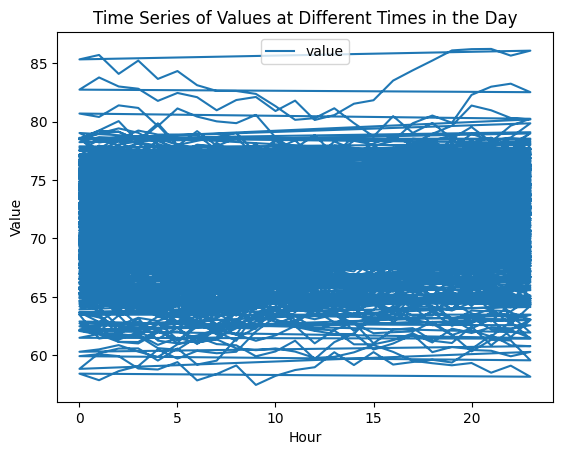

In [49]:
tdf1.plot(x = "hour", y = "value")
plt.xlabel("Hour")
plt.ylabel("Value")
plt.title("Time Series of Values at Different Times in the Day")
plt.show()

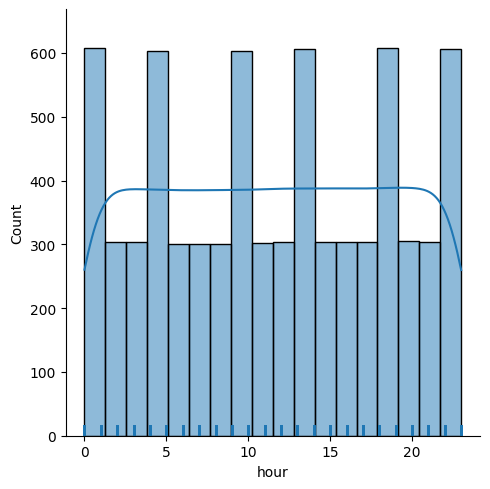

In [50]:
sns.displot(tdf1["hour"], kde = True, rug = True)
plt.show()

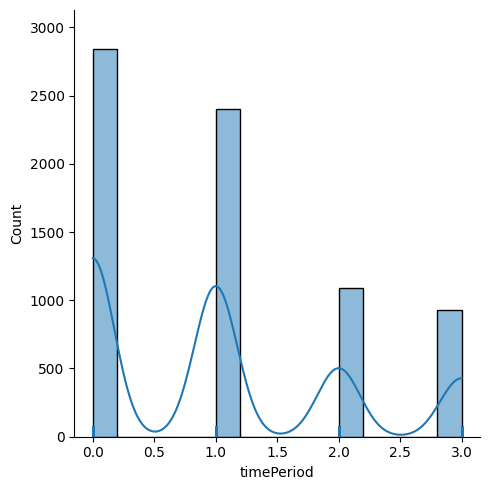

In [51]:
sns.displot(tdf1["timePeriod"], kde = True, rug = True)
plt.show()

In [52]:
tdf1.value.describe()

count    7267.000000
mean       71.242433
std         4.247509
min        57.458406
25%        68.369411
50%        71.858493
75%        74.430958
max        86.223213
Name: value, dtype: float64

In [53]:
outliers = px.scatter(tdf1, x = "timestamp", y = "value")
outliers.show()

In [54]:
outliers = px.box(tdf1, y = "value")
outliers.show()

**outliers_fraction = 0.01 (1%)**

In [55]:
import scipy
from sklearn.covariance import EllipticEnvelope

In [56]:
covariance = EllipticEnvelope(contamination = 0.01).fit(tdf1[["value"]])
prediction = pd.DataFrame(covariance.predict(tdf1[["value"]]), columns = ["outlierDetection"])
tdf1Pred = pd.concat([tdf1, prediction], axis = 1)
tdf1Pred["outlierDetection"] = tdf1Pred["outlierDetection"].replace([-1, 1], [True, False])
score = pd.DataFrame(covariance.decision_function(tdf1[["value"]]), columns = ["score"])
tdf1Pred = pd.concat([tdf1Pred, score], axis=1)

In [57]:
outliers = tdf1Pred[tdf1Pred["outlierDetection"] == True]
outliers.head(3)

timestamp      value  dayOfWeek  day  time  hour  month  dayType  \
3699       3699  83.247886          2    5    22    22     12        1   
3702       3702  83.780995          3    6     1     1     12        1   
3717       3717  83.511630          3    6    16    16     12        1   

      timeframe  season  timePeriod  outlierDetection     score  
3699          1       0           3              True -0.259722  
3702          1       0           3              True -1.216688  
3717          0       0           2              True -0.727744

In [58]:
outliers.season.value_counts()

season
1    56
0    17
Name: count, dtype: int64

In [59]:
outliers.month.value_counts()

month
4     36
5     20
12    17
Name: count, dtype: int64

In [60]:
outliers.day.value_counts()

day
6    47
0    23
5     3
Name: count, dtype: int64

In [61]:
outliers.timePeriod.value_counts()

timePeriod
2    29
3    21
1    20
0     3
Name: count, dtype: int64

In [62]:
visual = px.box(tdf1Pred, x = "outlierDetection", y = "score")
visual.show()

In [63]:
outliers = px.scatter(tdf1Pred, x = "timestamp", y = "value", color = "outlierDetection")
outliers.show()

In [64]:
prediction.shape

(7267, 1)

In [65]:
pd.DataFrame(prediction).value_counts()

outlierDetection
 1                  7194
-1                    73
Name: count, dtype: int64

**Calculating outliers_fraction by finding the total number of outliers via the IQR Method (1.5 x IQR rule).**

In [66]:
tdf1.describe()

timestamp        value    dayOfWeek          day         time  \
count  7267.000000  7267.000000  7267.000000  7267.000000  7267.000000   
mean   3633.000000    71.242433     3.008807     2.988579    11.509289   
std    2097.946536     4.247509     2.010892     1.979945     6.927370   
min       0.000000    57.458406     0.000000     0.000000     0.000000   
25%    1816.500000    68.369411     1.000000     1.000000     5.500000   
50%    3633.000000    71.858493     3.000000     3.000000    12.000000   
75%    5449.500000    74.430958     5.000000     5.000000    18.000000   
max    7266.000000    86.223213     6.000000     6.000000    23.000000   

              hour        month      dayType    timeframe       season  \
count  7267.000000  7267.000000  7267.000000  7267.000000  7267.000000   
mean     11.509289     6.539012     0.278519     0.458511     1.215357   
std       6.927370     3.700338     0.448301     0.498310     1.129392   
min       0.000000     1.000000     0.000000     0.000000     0.000000   
25%       5.500000     3.000000     0.000000     0.000000     0.000000   
50%      12.000000     7.000000     0.000000     0.000000     1.000000   
75%      18.000000    10.000000     1.000000     1.000000     2.000000   
max      23.000000    12.000000     1.000000     1.000000     3.000000   

        timePeriod  
count  7267.000000  
mean      1.015550  
std       1.026838  
min       0.000000  
25%       0.000000  
50%       1.000000  
75%       2.000000  
max       3.000000

In [67]:
Q1 = tdf1[["hour", "value"]].quantile(0.25)
Q3 = tdf1[["hour", "value"]].quantile(0.75)
IQR = Q3 - Q1

print(Q1)
print(Q3)
print(IQR)

hour      5.500000
value    68.369411
Name: 0.25, dtype: float64
hour     18.000000
value    74.430958
Name: 0.75, dtype: float64
hour     12.500000
value     6.061547
dtype: float64


**Identifying outliers with the 1.5 x IQR rule.**

https://www.khanacademy.org/math/statistics-probability/summarizing-quantitativedata/box-whisker-plots/a/identifying-outliers-iqr-rule

In [68]:
lowerRange = Q1 - (1.5 * IQR)
upperRange = Q3 + (1.5 * IQR)

print(lowerRange)
print(upperRange)

hour    -13.250000
value    59.277089
dtype: float64
hour     36.750000
value    83.523279
dtype: float64


Text(0, 0.5, 'Value')

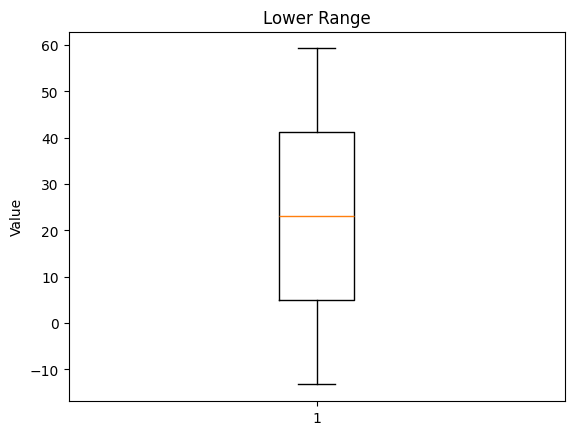

In [69]:
plt.boxplot(lowerRange)
plt.title("Lower Range")
plt.ylabel("Value")

Text(0, 0.5, 'Value')

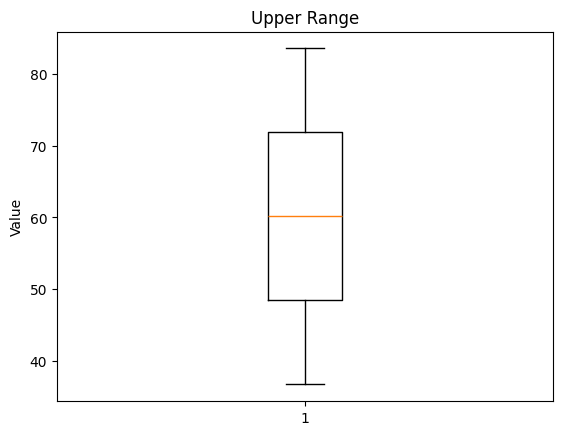

In [70]:
plt.boxplot(upperRange)
plt.title("Upper Range")
plt.ylabel("Value")

**Applying Isolation Forest for each category, and listing anomalies / showing them graphically.**

**outliers_fraction = 0.01 (1%)**

In [71]:
from sklearn.ensemble import IsolationForest

covariance2 = IsolationForest(contamination = 0.01)
covariance2 = covariance2.fit(tdf1[["value"]])
prediction2 = pd.DataFrame(covariance2.predict(tdf1[["value"]]), columns = ["outlierDetection"])
tdf1Pred2 = pd.concat([tdf1, prediction2], axis = 1)
tdf1Pred2["outlierDetection"] = tdf1Pred2["outlierDetection"].replace([-1, 1], [True, False])
score2 = pd.DataFrame(covariance2.decision_function(tdf1[["value"]]), columns = ["score"])
tdf1Pred2 = pd.concat([tdf1Pred2, score], axis = 1)

In [72]:
outliers2 = tdf1Pred2[tdf1Pred2["outlierDetection"] == True]
outliers2.head(3)

timestamp      value  dayOfWeek  day  time  hour  month  dayType  \
3695       3695  80.520263          2    5    18    18     12        1   
3697       3697  82.289240          2    5    20    20     12        1   
3698       3698  82.989869          2    5    21    21     12        1   

      timeframe  season  timePeriod  outlierDetection     score  
3695          0       0           2              True  3.958589  
3697          1       0           3              True  1.352105  
3698          1       0           3              True  0.187877

In [73]:
outliers2.season.value_counts()

season
0    45
1    26
3     2
Name: count, dtype: int64

In [74]:
outliers2.month.value_counts()

month
12    45
4     16
5     10
1      2
Name: count, dtype: int64

In [75]:
outliers2.day.value_counts()

day
6    45
0    18
5     5
1     5
Name: count, dtype: int64

In [76]:
outliers2.timePeriod.value_counts()

timePeriod
2    25
3    25
1    17
0     6
Name: count, dtype: int64

In [77]:
visual2 = px.box(tdf1Pred2, x = "outlierDetection", y = "score")
visual2.show()

In [78]:
outliers2 = px.scatter(tdf1Pred2, x = "timestamp", y = "value", color = "outlierDetection")
outliers2.show()

In [79]:
prediction2.shape

(7267, 1)

In [80]:
pd.DataFrame(prediction2).value_counts()

outlierDetection
 1                  7194
-1                    73
Name: count, dtype: int64

**Calculate outliers_fraction by finding total number of outliers via the IQR Method (1.5 x IQR rule).**

In [81]:
tdf1.describe()

timestamp        value    dayOfWeek          day         time  \
count  7267.000000  7267.000000  7267.000000  7267.000000  7267.000000   
mean   3633.000000    71.242433     3.008807     2.988579    11.509289   
std    2097.946536     4.247509     2.010892     1.979945     6.927370   
min       0.000000    57.458406     0.000000     0.000000     0.000000   
25%    1816.500000    68.369411     1.000000     1.000000     5.500000   
50%    3633.000000    71.858493     3.000000     3.000000    12.000000   
75%    5449.500000    74.430958     5.000000     5.000000    18.000000   
max    7266.000000    86.223213     6.000000     6.000000    23.000000   

              hour        month      dayType    timeframe       season  \
count  7267.000000  7267.000000  7267.000000  7267.000000  7267.000000   
mean     11.509289     6.539012     0.278519     0.458511     1.215357   
std       6.927370     3.700338     0.448301     0.498310     1.129392   
min       0.000000     1.000000     0.000000     0.000000     0.000000   
25%       5.500000     3.000000     0.000000     0.000000     0.000000   
50%      12.000000     7.000000     0.000000     0.000000     1.000000   
75%      18.000000    10.000000     1.000000     1.000000     2.000000   
max      23.000000    12.000000     1.000000     1.000000     3.000000   

        timePeriod  
count  7267.000000  
mean      1.015550  
std       1.026838  
min       0.000000  
25%       0.000000  
50%       1.000000  
75%       2.000000  
max       3.000000

In [82]:
Q1_2 = tdf1[["hour", "value"]].quantile(0.25)
Q3_2 = tdf1[["hour", "value"]].quantile(0.75)
IQR_2 = Q3_2 - Q1_2

print(Q1_2)
print(Q3_2)
print(IQR_2)

hour      5.500000
value    68.369411
Name: 0.25, dtype: float64
hour     18.000000
value    74.430958
Name: 0.75, dtype: float64
hour     12.500000
value     6.061547
dtype: float64


**Identifying outliers with the 1.5 x IQR rule.**

In [83]:
lowerRange2 = Q1_2 - (1.5 * IQR_2)
upperRange2 = Q3_2 + (1.5 * IQR_2)

print(lowerRange2)
print(upperRange2)

hour    -13.250000
value    59.277089
dtype: float64
hour     36.750000
value    83.523279
dtype: float64


Text(0, 0.5, 'Value')

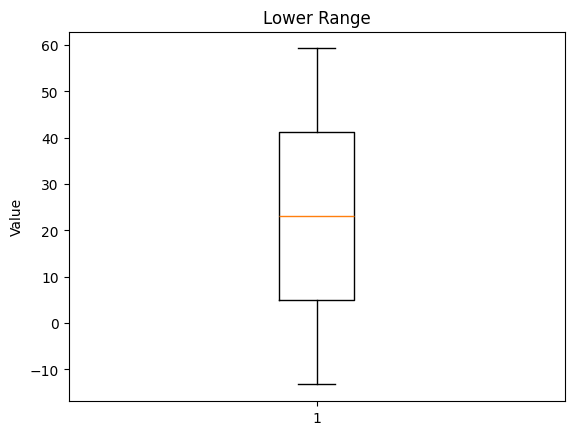

In [84]:
plt.boxplot(lowerRange2)
plt.title("Lower Range")
plt.ylabel("Value")

Text(0, 0.5, 'Value')

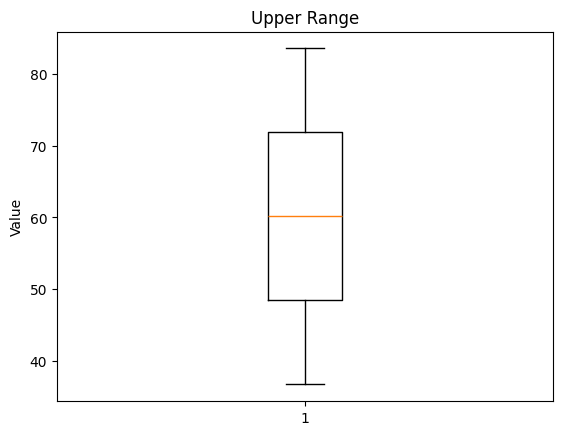

In [85]:
plt.boxplot(upperRange2)
plt.title("Upper Range")
plt.ylabel("Value")